In [1]:
%matplotlib widget

#from IPython import display
from base64 import b64decode
from pacti import write_contracts_to_file
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import *

## Power viewpoint modeling

### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery charges proportionally to a generation rate.

Contract charging1_power:

InVars: [soc2_entry, duration_charging2]
OutVars:[soc2_exit]
A: [
  -duration_charging2 <= 0.0
  -soc2_entry <= 0.0
]
G: [
  -4.0 duration_charging2 - soc2_entry + soc2_exit <= 0.0
  3.0 duration_charging2 + soc2_entry - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


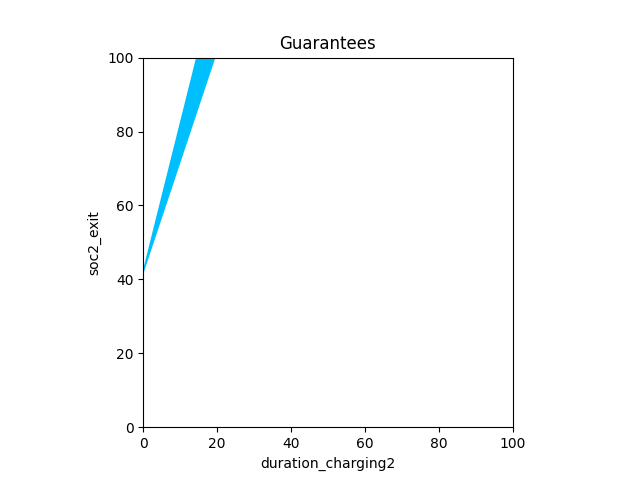

In [2]:
# Parameters:
# - s: index of the timeline variables
# - generation: (min, max) rate of battery charge during the task instance
def CHRG_power(s: int, generation: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"soc{s}_entry",          # initial battery SOC
      f"duration_charging{s}",  # variable task duration
    ],
    output_vars = [
      f"soc{s}_exit",           # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_charging{s} <= 0",

      # Battery SOC must be positive
      f"-soc{s}_entry <= 0",
    ],
    guarantees = [
      # duration*generation(min) <= soc{exit} - soc{entry} <= duration*generation(max)
      f" soc{s}_exit - soc{s}_entry - {generation[1]}*duration_charging{s} <= 0",
      f"-soc{s}_exit + soc{s}_entry + {generation[0]}*duration_charging{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

charging1_power = CHRG_power(s=2, generation=(3.0, 4.0))
print(f"Contract charging1_power:\n\n{charging1_power}")

_ = plot_guarantees(contract=charging1_power,
                x_var=Var("duration_charging2"),
                y_var=Var("soc2_exit"),
                var_values={
                  Var("soc2_entry"):42,
                },
                x_lims=(0,100),
                y_lims=(0,100))

### Power-consuming Tasks (DSN, SBO, TCM)

In [3]:
# Parameters:
# - s: start index of the timeline variables
# - consumption: (min, max) rate of battery discharge during the task instance
def power_consumer(s: int, task: str, consumption: tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"soc{s}_entry",          # initial battery SOC
      f"duration_{task}{s}",    # variable task duration
    ],
    output_vars = [
      f"soc{s}_exit",           # final battery SOC
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_{task}{s} <= 0",

      # Battery has enough energy for worst-case consumption throughout the task instance
      f"-soc{s}_entry + {consumption[1]}*duration_{task}{s} <= 0",
    ],
    guarantees = [
      # duration*consumption(min) <= soc{entry} - soc{exit} <= duration*consumption(max)
      f" soc{s}_entry - soc{s}_exit - {consumption[1]}*duration_{task}{s} <= 0",
      f"-soc{s}_entry + soc{s}_exit + {consumption[0]}*duration_{task}{s} <= 0",

      # Battery cannot exceed maximum SOC
      f"soc{s}_exit <= 100.0",
      
      # Battery should not completely discharge
      f"-soc{s}_exit <= 0",
    ])
  return spec

### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery discharges proportionally to a consumption rate.


Contract dsn1_power:

InVars: [soc1_entry, duration_dsn1]
OutVars:[soc1_exit]
A: [
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 + soc1_entry - soc1_exit <= 0.0
  3.8 duration_dsn1 - soc1_entry + soc1_exit <= 0.0
  soc1_exit <= 100.0
]


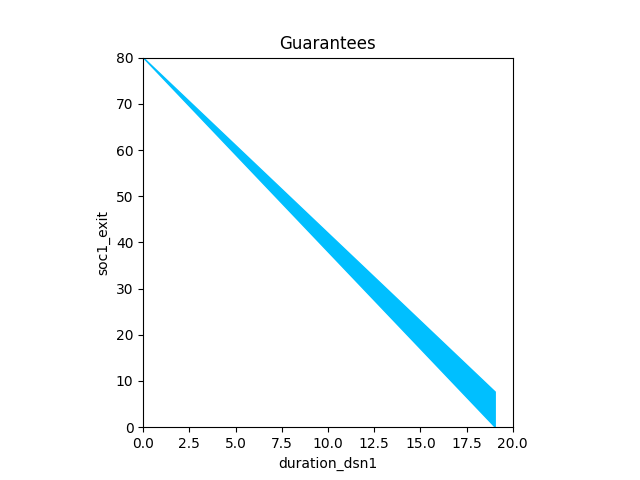

In [4]:
dsn1_power = power_consumer(s=1, task="dsn", consumption=(3.8, 4.2))
print(f"Contract dsn1_power:\n\n{dsn1_power}")

_ = plot_guarantees(contract=dsn1_power,
                x_var=Var("duration_dsn1"),
                y_var=Var("soc1_exit"),
                var_values={
                  Var("soc1_entry"):80,
                },
                x_lims=(0,20),
                y_lims=(0,80))

### SBO Task (Small body observations)

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the battery discharges proportionally to a consumption rate.

Contract sbo1_power:

InVars: [soc3_entry, duration_sbo3]
OutVars:[soc3_exit]
A: [
  -duration_sbo3 <= 0.0
  1.4 duration_sbo3 - soc3_entry <= 0.0
]
G: [
  -1.4 duration_sbo3 + soc3_entry - soc3_exit <= 0.0
  duration_sbo3 - soc3_entry + soc3_exit <= 0.0
  soc3_exit <= 100.0
]


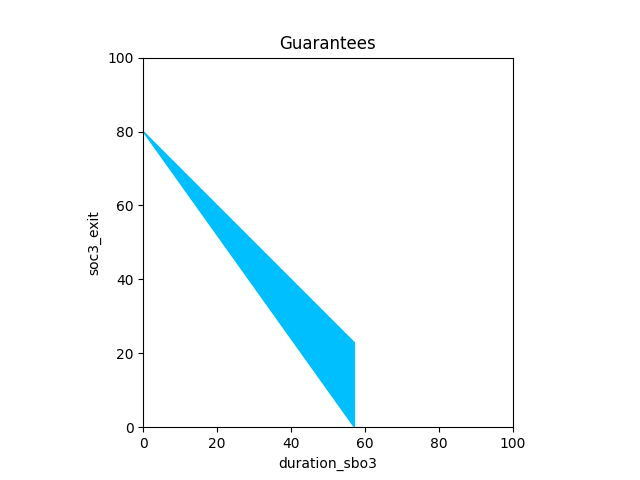

In [5]:
sbo1_power = power_consumer(s=3, task="sbo", consumption=(1.0, 1.4))
print(f"Contract sbo1_power:\n\n{sbo1_power}")

_ = plot_guarantees(contract=sbo1_power,
                x_var=Var("duration_sbo3"),
                y_var=Var("soc3_exit"),
                var_values={
                  Var("soc3_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- Power: the thrusters must be heated before firing them, thereby discharging the battery proportionally to a consumption rate.

Since heating the thruster must happen just before firing them, this task is modeled as the composition of two subtasks: Heating and DeltaV.

#### TCM Heating SubTask


Contract tcm1_heating_power:

InVars: [soc4_entry, duration_tcm_heating4]
OutVars:[soc4_exit]
A: [
  -duration_tcm_heating4 <= 0.0
  0.8 duration_tcm_heating4 - soc4_entry <= 0.0
]
G: [
  -0.8 duration_tcm_heating4 + soc4_entry - soc4_exit <= 0.0
  0.7 duration_tcm_heating4 - soc4_entry + soc4_exit <= 0.0
  soc4_exit <= 100.0
]


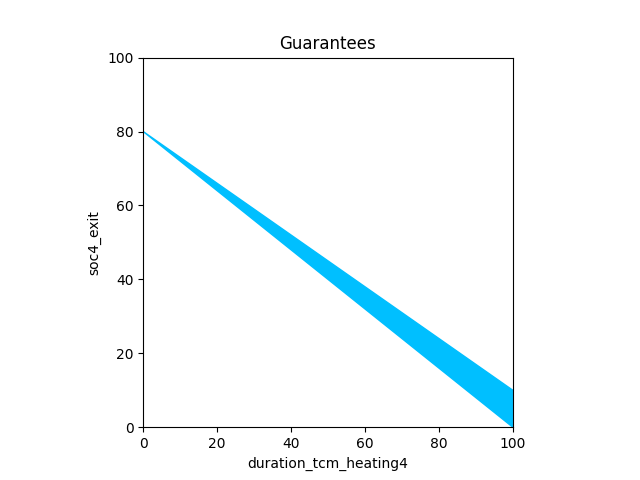

In [6]:
tcm1_heating_power = power_consumer(s=4, task="tcm_heating", consumption=(0.7, 0.8))
print(f"Contract tcm1_heating_power:\n\n{tcm1_heating_power}")

_ = plot_guarantees(contract=tcm1_heating_power,
                x_var=Var("duration_tcm_heating4"),
                y_var=Var("soc4_exit"),
                var_values={
                  Var("soc4_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### TCM DeltaV SubTask


Contract tcm1_deltav_power:

InVars: [soc5_entry, duration_tcm_deltav5]
OutVars:[soc5_exit]
A: [
  -duration_tcm_deltav5 <= 0.0
  0.6 duration_tcm_deltav5 - soc5_entry <= 0.0
]
G: [
  -0.6 duration_tcm_deltav5 + soc5_entry - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - soc5_entry + soc5_exit <= 0.0
  soc5_exit <= 100.0
]


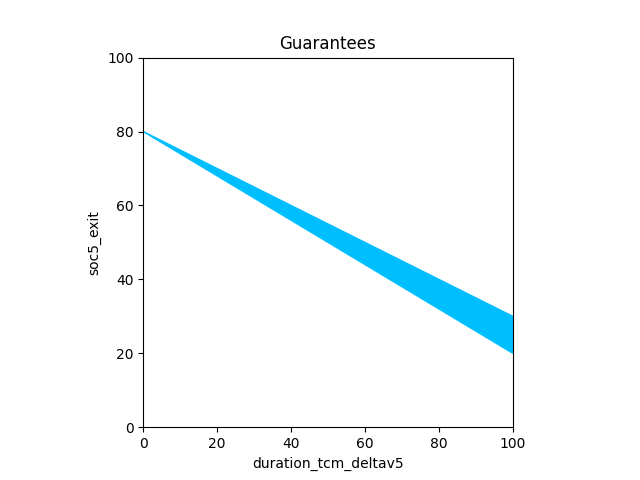

In [7]:
tcm1_deltav_power = power_consumer(s=5, task="tcm_deltav", consumption=(0.5, 0.6))
print(f"Contract tcm1_deltav_power:\n\n{tcm1_deltav_power}")

_ = plot_guarantees(contract=tcm1_deltav_power,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("soc5_exit"),
                var_values={
                  Var("soc5_entry"):80,
                },
                x_lims=(0,100),
                y_lims=(0,100))

#### Composing TCM SubTasks

Algebraic composition allows us to capture the requirement that a TCM Heating subtask must always precede a TCM DeltaV subtask by composing them.

In [8]:
tcm1_power=scenario_sequence(c1=tcm1_heating_power, c2=tcm1_deltav_power, variables=["soc"], c1index=4)
print(f"========= tcm1_power\n{tcm1_power}")
tcm1_power.get_variable_bounds("soc5_exit")

========= tcm1_power
InVars: [soc4_entry, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[soc5_exit, output_soc4]
A: [
  -duration_tcm_deltav5 <= 0.0
  0.6 duration_tcm_deltav5 + 0.8 duration_tcm_heating4 - soc4_entry <= 0.0
  -duration_tcm_heating4 <= 0.0
]
G: [
  -0.8 duration_tcm_heating4 - output_soc4 + soc4_entry <= 0.0
  0.7 duration_tcm_heating4 + output_soc4 - soc4_entry <= 0.0
  output_soc4 <= 100.0
  -0.6 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - output_soc4 + soc5_exit <= 0.0
]


(-1.4210854715202004e-14, 100.0)

### Power Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [9]:
steps12=scenario_sequence(c1=dsn1_power, c2=charging1_power, variables=["soc"], c1index=1)
print(f"---- Steps 1,2\n{steps12}")
steps12.get_variable_bounds("output_soc1")

---- Steps 1,2
InVars: [soc1_entry, duration_dsn1, duration_charging2]
OutVars:[soc2_exit, output_soc1]
A: [
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + soc2_exit <= 0.0
  3.0 duration_charging2 + output_soc1 - soc2_exit <= 0.0
  soc2_exit <= 100.0
]


(0.0, 100.0)

In [10]:
steps123=scenario_sequence(c1=steps12, c2=sbo1_power, variables=["soc"], c1index=2)
print(f"---- Steps 1,2,3\n{steps123}")
print(steps123.get_variable_bounds("soc3_exit"))
print(steps123.get_variable_bounds("duration_dsn1"))
print(steps123.get_variable_bounds("duration_charging2"))
print(steps123.get_variable_bounds("duration_sbo3"))

---- Steps 1,2,3
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3]
OutVars:[output_soc1, soc3_exit, output_soc2]
A: [
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + output_soc2 <= 0.0
  3.0 duration_charging2 + output_soc1 - output_soc2 <= 0.0
  output_soc2 <= 100.0
  -1.4 duration_sbo3 + output_soc2 - soc3_exit <= 0.0
  duration_sbo3 - output_soc2 + soc3_exit <= 0.0
]
(None, 100.0)
(0.0, None)
(0.0, 33.333333333333336)
(0.0, None)


In [11]:
steps1234=scenario_sequence(c1=steps123, c2=tcm1_power, variables=["soc"], c1index=3)
print(f"---- Steps 1,2,3,4\n{steps1234}")
print(steps1234.get_variable_bounds("duration_dsn1"))
print(steps1234.get_variable_bounds("duration_charging2"))
print(steps1234.get_variable_bounds("duration_sbo3"))
print(steps1234.get_variable_bounds("duration_tcm_heating4"))
print(steps1234.get_variable_bounds("duration_tcm_deltav5"))

---- Steps 1,2,3,4
InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_soc1, output_soc2, soc5_exit, output_soc4, output_soc3]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_tcm_heating4 <= 0.0
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + output_soc2 <= 0.0
  3.0 duration_charging2 + output_soc1 - output_soc2 <= 0.0
  output_soc2 <= 100.0
  -1.4 duration_sbo3 + output_soc2 - output_soc3 <= 0.0
  duration_sbo3 - output_soc2 + output_soc3 <= 0.0
  -0.8 duration_tcm_heating4 + output_soc3 - output_soc4 <= 0.0
  0.7 duration_tcm_heating4 - output_soc3 + output_soc4 <= 0.0
  -0.6 duration_tcm_deltav5 + output_soc4 - soc5_exit <= 0.0
  0.5 duration_tcm_deltav5 - output_soc4 + soc5_exit 

#### Power Schedule constraints

In [12]:
scenario_power=steps1234.rename_variables([("soc5_exit", "output_soc5")])
print(f"scenario_power={scenario_power}")

scenario_power=InVars: [soc1_entry, duration_dsn1, duration_charging2, duration_sbo3, duration_tcm_heating4, duration_tcm_deltav5]
OutVars:[output_soc1, output_soc2, output_soc4, output_soc3, output_soc5]
A: [
  -duration_tcm_deltav5 <= 0.0
  -duration_tcm_heating4 <= 0.0
  -duration_sbo3 <= 0.0
  -duration_charging2 <= 0.0
  -duration_dsn1 <= 0.0
  4.2 duration_dsn1 - soc1_entry <= 0.0
]
G: [
  -4.2 duration_dsn1 - output_soc1 + soc1_entry <= 0.0
  3.8 duration_dsn1 + output_soc1 - soc1_entry <= 0.0
  -4.0 duration_charging2 - output_soc1 + output_soc2 <= 0.0
  3.0 duration_charging2 + output_soc1 - output_soc2 <= 0.0
  output_soc2 <= 100.0
  -1.4 duration_sbo3 + output_soc2 - output_soc3 <= 0.0
  duration_sbo3 - output_soc2 + output_soc3 <= 0.0
  -0.8 duration_tcm_heating4 + output_soc3 - output_soc4 <= 0.0
  0.7 duration_tcm_heating4 - output_soc3 + output_soc4 <= 0.0
  -0.6 duration_tcm_deltav5 + output_soc4 - output_soc5 <= 0.0
  0.5 duration_tcm_deltav5 - output_soc4 + output_soc

In [13]:
write_contracts_to_file(contracts=[scenario_power], names=["scenario_power"], file_name="json/scenario_power.json")